# IV Surface

The implied volatility surface simultaneously shows both volatility smile and term structure of volatility. Option traders use an implied volatility plot to quickly determine the shape of the implied volatility surface, and to identify any areas where the slope of the plot (and therefore relative implied volatilities) seems out of line.

Content:

- [Load Data](#load-data)
- [Model](#Model) 
- [IV Code](#IV-code)
- [Calls IV](#Call-IV)
- [Puts IV](#Puts-IV)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.optimize import fsolve
import scipy as sq
from scipy import stats


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [9]:
synthetic_options_path = '../data/heston_synthetic_options.csv'
call_sample_path = '../data/heston_calls_iv.csv'
put_sample_path = '../data/heston_puts_iv.csv'

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [11]:
synthetic_options = pd.read_csv(synthetic_options_path, index_col=0)
synthetic_options = reduce_mem_usage(synthetic_options)

/home/paolo/PycharmProjects/backtesting_experiments/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
synthetic_options = shuffle(synthetic_options, random_state=0)
synthetic_options = synthetic_options.reset_index()
synthetic_options = synthetic_options.drop('index', axis=1)

In [13]:
synthetic_options

,Price,Strike,Type,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,Option Price
0,96,78.0,C,1.074219,-0.311279,0.375732,0.180298,0.367432,0.045074,0.533203,17.828125
1,100,56.0,C,1.495117,-0.869629,0.011398,0.010925,0.257080,0.050201,0.977051,42.187500
2,100,68.0,P,0.988770,-0.664551,0.344482,0.045258,0.328125,0.051971,0.588867,0.026703
3,100,75.0,C,1.996094,-0.051880,0.417480,0.208374,0.328613,0.053741,0.215088,25.312500
4,100,71.0,P,0.344971,-0.344727,0.227783,0.340820,0.054413,0.016891,0.800781,0.070496
...,...,...,...,...,...,...,...,...,...,...,...
1059740,100,71.0,P,1.039062,-0.757324,0.227661,0.312500,0.445068,0.016006,0.487061,1.505859
1059741,100,57.0,C,1.905273,-0.276855,0.322266,0.061432,0.120117,0.025070,0.947754,41.687500
1059742,92,132.0,P,0.149536,-0.433350,0.262695,0.054565,0.404541,0.028809,0.551758,38.375000
1059743,100,135.0,C,0.971680,-0.711426,0.270508,0.438477,0.483887,0.097107,0.289307,0.180542


In [14]:
call_sample = pd.read_csv(call_sample_path, index_col=0)
put_sample = pd.read_csv(put_sample_path, index_col=0)

## Preprocessing

In [15]:
synthetic_options = pd.get_dummies(synthetic_options, prefix='', prefix_sep='')

In [16]:
synthetic_options.drop('Option Price', axis=1).columns

Index(['Price', 'Strike', 'Kappa', 'Rho', 'Theta', 'Xi', 'V_0',
       'Interest Rate', 'Time to Expiration', 'C', 'P'],
      dtype='object')

In [17]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(synthetic_options.drop('Option Price', axis=1))
output_data = output_sc.fit_transform(synthetic_options['Option Price'].values.reshape(-1, 1))

## Model

In [18]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [19]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [20]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [21]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [22]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

In [23]:
input_size = 11
output_size = 1
num_layers = 4
hidden_size = 600
batch_size = 1141
epochs = 2000
lr = 0.00012243587926335812
init_method = 'xaiver uniform'
act_fn = 'LeakyReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()

In [24]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

In [25]:
save_model_path = '../models/final_heston_model.chkpt'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
model.load_state_dict(torch.load(save_model_path, map_location=device))
model = model.to(device)

## IV code

There two different approaches for derive IV:

**Closed form approximations**: usually are closed form solution derived directly from the Black Scholes model, they tend to work fine when finding IV of ATM options. As soon the underlying price departs from the strike price it very quickly loses accuracy. Close form solutions are: Brenner & Subrahmanyam formula, Bharadia, Christofides and Salkin formula, Corrado & Miller and others

**Numerical methods**: they involves the use of root finding algorithm for obtaining the volatility value $\sigma$ such that the function:

$$
f(\sigma) = C - g(\sigma)
$$

vanishes i.e. that the price of the call $C$ (or the put $P$) observed on the market is the same as the expressed by the value $g(\sigma)$ proposed by the algorithm.

In [26]:
def get_d1_d2(S, X, T, t, r, sigma):
    """
    Compute d1 and d2 values for the black-scholes pricing model


    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate
    :param sigma: underlying volatility
    :return: (d1, d2)
    """
    d1 = (np.log(S / X) + (r + sigma * sigma / 2.) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return d1, d2


def black_scholes(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute option price using the black-scholes model

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the black-scholes option price
    """
    d1, d2 = get_d1_d2(S, X, T, t, r, sigma)
    if o_type == "C":
        return S * stats.norm.cdf(d1, 0, 1) - X * np.exp(-r * (T - t)) * stats.norm.cdf(d2, 0, 1)
    else:
        return X * np.exp(-r * (T - t)) * stats.norm.cdf(-d2, 0, 1) - S * stats.norm.cdf(-d1, 0, 1)

### Newton method

In the newton method the starting point used is the inflecion point of $g(\sigma)$ which is $\sigma_F = \sqrt{\frac{2 |\log(S/K)|}{T}}$.

As shown in [Giuseppe Orlando et al](https://www.sciencedirect.com/science/article/pii/S0377042717300602) $\sigma_F$ gives faster performance comparing to others starting points.

In [27]:
def IV_newton(CallPutFlag, S, X, T, r, Option_Value):

    def obj_function(IV):
        result = Option_Value - black_scholes(S, X, T, 0, r, IV, CallPutFlag)
        return result

    x0 = np.sqrt((2 * np.abs(np.log(S/X))) / T)
    
    try:
      IV_Result = sq.optimize.newton(obj_function, x0=x0)
    except RuntimeError:
      IV_Result = np.nan
    except ValueError:
      IV_Result = np.nan

    return IV_Result

### Brent method

In [28]:
def IV_brent(CallPutFlag, S, X, T, r, Option_Value):

    def obj_function(IV):
        result = Option_Value - black_scholes(S, X, T, 0, r, IV, CallPutFlag)
        return result

    x0 = np.sqrt((2 * np.abs(np.log(S/X))) / T)
    
    try:
      IV_Result = sq.optimize.brenth(obj_function, a=0.01, b=2.5, xtol=0.000001)
    except RuntimeError:
      IV_Result = np.nan
    except ValueError:
      IV_Result = np.nan

    return IV_Result

### Brenner & Subrahmanyam formula

In [29]:
def iv_bs(CallPutFlag, S, X, T, r, Option_Value):
    if CallPutFlag == 'C':
      return (np.sqrt(2 * np.pi / T) * S / X) / 10
    else:
      return (np.sqrt(2 * np.pi / T) * X / S) / 10

## Calls IV

In [30]:
call_sample

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price
0,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.443166,1,0,33.938340
1,100,71,1.5,-0.05,0.45,0.3,0.25,0.02,0.443166,1,0,29.002430
2,100,76,1.5,-0.05,0.45,0.3,0.25,0.02,0.443166,1,0,24.047056
3,100,81,1.5,-0.05,0.45,0.3,0.25,0.02,0.443166,1,0,19.279959
4,100,86,1.5,-0.05,0.45,0.3,0.25,0.02,0.443166,1,0,14.697405
...,...,...,...,...,...,...,...,...,...,...,...,...
845,100,126,1.5,-0.05,0.45,0.3,0.25,0.02,0.940808,1,0,1.157259
846,100,131,1.5,-0.05,0.45,0.3,0.25,0.02,0.940808,1,0,0.890627
847,100,136,1.5,-0.05,0.45,0.3,0.25,0.02,0.940808,1,0,0.759873
848,100,141,1.5,-0.05,0.45,0.3,0.25,0.02,0.940808,1,0,0.602405


In [31]:
call_sample_t = input_sc.transform(call_sample.drop('Option Price', axis=1))
call_sample_t = Variable(torch.Tensor(call_sample_t))

In [33]:
with torch.no_grad():
    pred = model(call_sample_t.to(device))

pred = output_sc.inverse_transform(pred.detach().cpu().numpy())
call_sample['Prediction'] = pred
call_sample['Prediction'] = np.abs(call_sample['Prediction'].values)
call_sample['Moneyness'] = call_sample.Price / call_sample.Strike

In [34]:
call_sample.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price,Prediction,Moneyness
458,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.021964,1,0,0.000000,0.561228,0.684932
101,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.047391,1,0,0.000000,0.458817,0.684932
356,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.066740,1,0,0.000000,0.388171,0.684932
747,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.087278,1,0,0.000000,0.324623,0.684932
798,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.106436,1,0,0.000000,0.264626,0.684932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,1.005620,1,0,32.670650,33.679863,1.515152
748,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,1.017386,1,0,32.719843,33.652935,1.515152
102,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,1.037411,1,0,32.865674,33.607693,1.515152
629,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,1.063276,1,0,32.973942,33.571186,1.515152


In [35]:
call_sample_iv = call_sample.copy()
call_sample_iv_ = call_sample.copy()
call_sample_iv['IV'] = np.nan
call_sample_iv['Model IV'] = np.nan
call_sample_iv_['IV'] = np.nan
call_sample_iv_['Model IV'] = np.nan

In [36]:
call_sample_iv['Model IV'] = call_sample_iv.apply(lambda x: IV_newton('C', x[0], x[1], x[8], x[7], x[12]), axis=1)
call_sample_iv['IV'] = call_sample_iv.apply(lambda x: IV_newton('C', x[0], x[1], x[8], x[7], x[11]), axis=1)
call_sample_iv_['Model IV'] = call_sample_iv_.apply(lambda x: IV_brent('C', x[0], x[1], x[8], x[7], x[12]), axis=1)
call_sample_iv_['IV'] = call_sample_iv_.apply(lambda x: IV_brent('C', x[0], x[1], x[8], x[7], x[11]), axis=1)

In [37]:
call_sample_iv = call_sample_iv.dropna()
call_sample_iv = call_sample_iv[call_sample_iv.IV != 0]
call_sample_iv = call_sample_iv[call_sample_iv['Model IV'] != 0]
call_sample_iv = call_sample_iv.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])
call_sample_iv

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price,Prediction,Moneyness,IV,Model IV
509,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.133080,1,0,0.093308,0.168421,0.684932,0.463527,0.504735
781,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.150339,1,0,0.496073,0.109976,0.684932,0.572072,0.445780
237,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.182041,1,0,0.395013,0.009314,0.684932,0.497144,0.305697
50,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.205408,1,0,0.318976,0.080978,0.684932,0.449819,0.364887
492,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.214559,1,0,0.395946,0.118083,0.684932,0.457503,0.375848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,100,86,1.5,-0.05,0.45,0.3,0.25,0.02,0.313578,1,0,15.679246,14.691132,1.162791,0.275198,0.164476
514,100,86,1.5,-0.05,0.45,0.3,0.25,0.02,0.398751,1,0,15.216455,14.724133,1.162791,0.195460,0.118082
564,100,81,1.5,-0.05,0.45,0.3,0.25,0.02,0.313578,1,0,20.111327,19.656462,1.234568,0.289075,0.214226
513,100,81,1.5,-0.05,0.45,0.3,0.25,0.02,0.398751,1,0,20.340773,19.669718,1.234568,0.267692,0.147358


In [38]:
call_sample_iv_ = call_sample_iv_.dropna()
call_sample_iv_ = call_sample_iv_[call_sample_iv_.IV != 0]
call_sample_iv_ = call_sample_iv_[call_sample_iv_['Model IV'] != 0]
call_sample_iv_ = call_sample_iv_.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])
call_sample_iv_

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price,Prediction,Moneyness,IV,Model IV
458,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.021964,1,0,0.000000,0.561228,0.684932,0.010000,1.541854
101,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.047391,1,0,0.000000,0.458817,0.684932,0.010000,1.007859
356,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.066740,1,0,0.000000,0.388171,0.684932,0.010000,0.822342
747,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.087278,1,0,0.000000,0.324623,0.684932,0.010000,0.695669
798,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,0.106436,1,0,0.000000,0.264626,0.684932,0.010000,0.607610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,100,86,1.5,-0.05,0.45,0.3,0.25,0.02,0.313578,1,0,15.679246,14.691132,1.162791,0.275198,0.164476
514,100,86,1.5,-0.05,0.45,0.3,0.25,0.02,0.398751,1,0,15.216455,14.724133,1.162791,0.195460,0.118082
564,100,81,1.5,-0.05,0.45,0.3,0.25,0.02,0.313578,1,0,20.111327,19.656462,1.234568,0.289075,0.214226
513,100,81,1.5,-0.05,0.45,0.3,0.25,0.02,0.398751,1,0,20.340773,19.669718,1.234568,0.267693,0.147358


In [39]:
X_axis = call_sample_iv.Moneyness
Y_axis = call_sample_iv['Time to Expiration']
Z_axis = call_sample_iv.IV
X_axis_ = call_sample_iv_.Moneyness
Y_axis_ = call_sample_iv_['Time to Expiration']
Z_axis_ = call_sample_iv_.IV

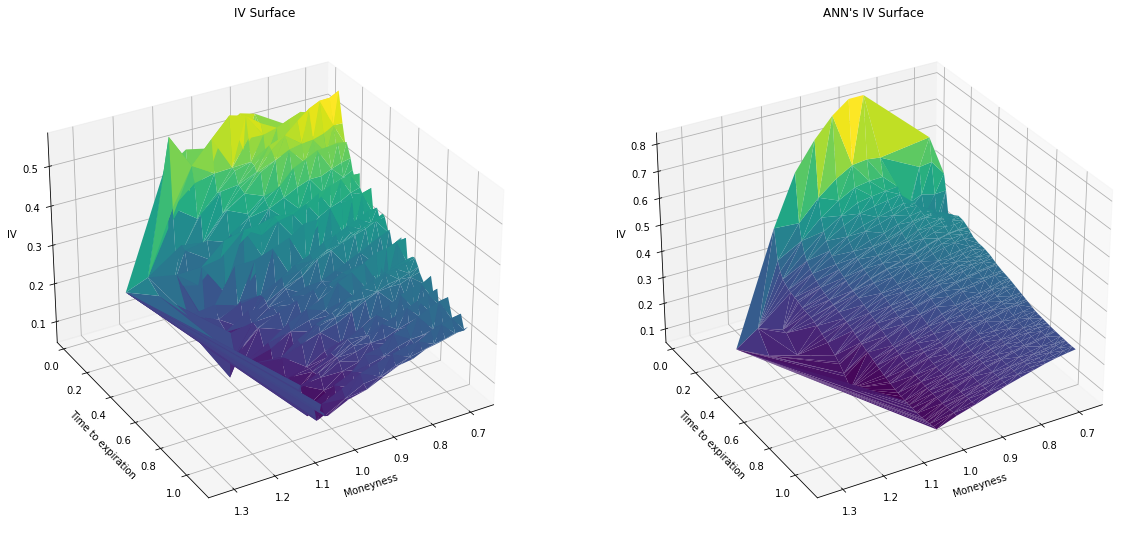

In [40]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, Z_axis, 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('IV Surface')
ax.view_init(30, 60)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, call_sample_iv['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('ANN\'s IV Surface')
ax.view_init(30, 60)

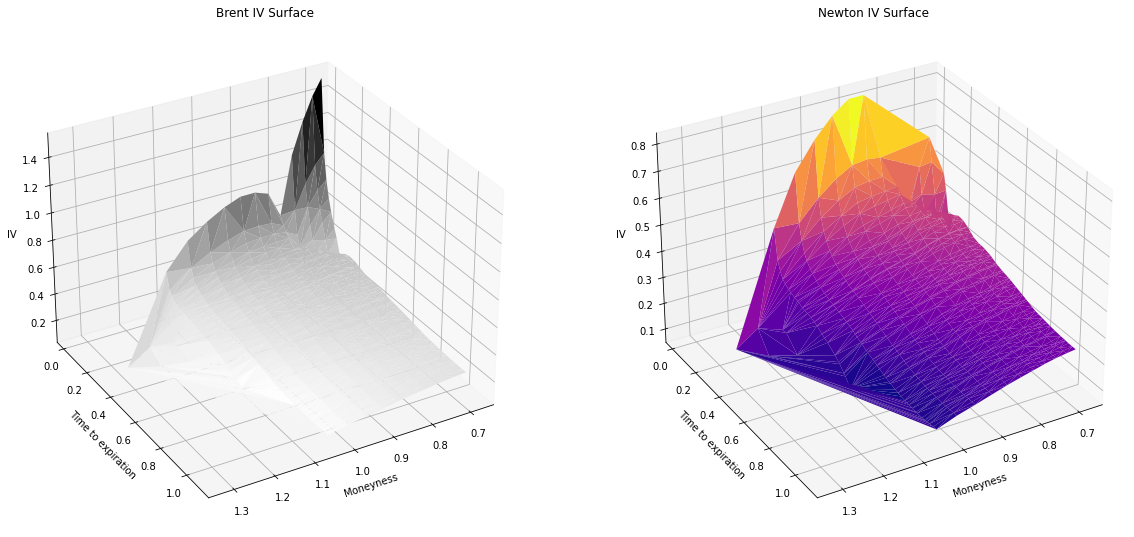

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_trisurf(X_axis_, Y_axis_, call_sample_iv_['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='binary')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('Brent IV Surface')
ax.view_init(30, 60)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, call_sample_iv['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='plasma')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('Newton IV Surface')
ax.view_init(30, 60)

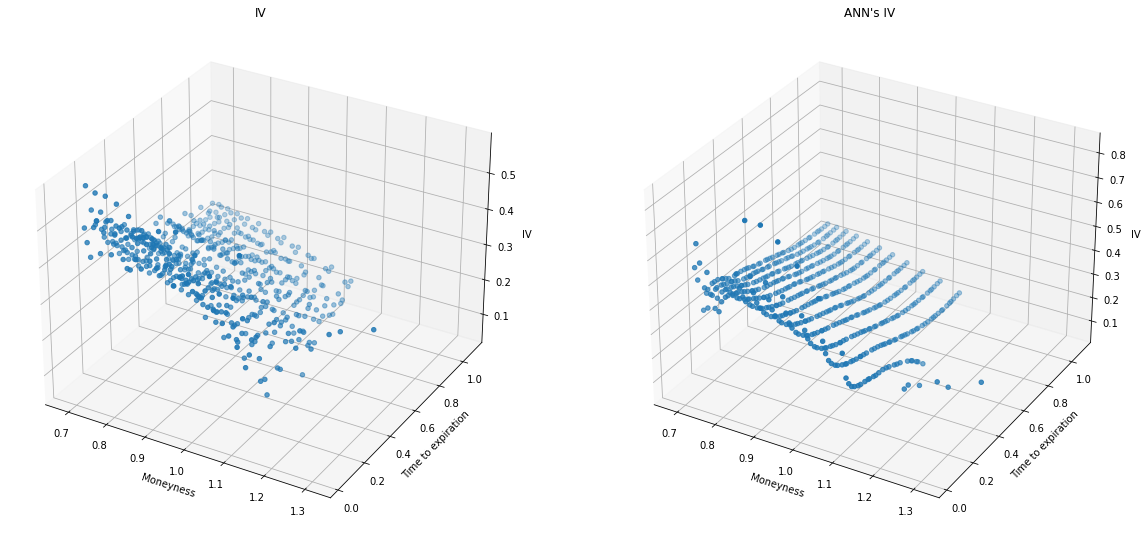

In [42]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(X_axis, Y_axis, call_sample_iv.IV)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('IV')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.scatter(X_axis, Y_axis, call_sample_iv['Model IV'])
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('ANN\'s IV')

plt.show()

## Puts IV

In [43]:
put_sample_t = input_sc.transform(put_sample.drop('Option Price', axis=1))
put_sample_t = Variable(torch.Tensor(put_sample_t))

In [44]:
with torch.no_grad():
    pred = model(put_sample_t.to(device))

pred = output_sc.inverse_transform(pred.detach().cpu().numpy())
put_sample['Prediction'] = pred
put_sample['Prediction'] = np.abs(put_sample['Prediction'].values)
put_sample['Moneyness'] = put_sample.Strike / put_sample.Price

In [45]:
put_sample_iv = put_sample.copy()
put_sample_iv_ = put_sample.copy()
put_sample_iv['IV'] = np.nan
put_sample_iv['Model IV'] = np.nan
put_sample_iv_['IV'] = np.nan
put_sample_iv_['Model IV'] = np.nan

In [46]:
put_sample_iv['Model IV'] = put_sample_iv.apply(lambda x: IV_newton('P', x[0], x[1], x[8], x[7], x[12]), axis=1)
put_sample_iv['IV'] = put_sample_iv.apply(lambda x: IV_newton('P', x[0], x[1], x[8], x[7], x[11]), axis=1)
put_sample_iv_['Model IV'] = put_sample_iv_.apply(lambda x: IV_brent('P', x[0], x[1], x[8], x[7], x[12]), axis=1)
put_sample_iv_['IV'] = put_sample_iv_.apply(lambda x: IV_brent('P', x[0], x[1], x[8], x[7], x[11]), axis=1)

In [47]:
put_sample_iv = put_sample_iv.dropna()
put_sample_iv = put_sample_iv[put_sample_iv.IV != 0]
put_sample_iv = put_sample_iv[put_sample_iv['Model IV'] != 0]
put_sample_iv = put_sample_iv.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])
put_sample_iv

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price,Prediction,Moneyness,IV,Model IV
782,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.106436,0,1,0.079720,0.011819,0.66,0.586818,0.468610
765,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.150339,0,1,0.063199,0.110741,0.66,0.479257,0.518688
221,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.182041,0,1,0.026842,0.167005,0.66,0.392419,0.503173
34,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.205408,0,1,0.312656,0.193748,0.66,0.529051,0.485938
476,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.214559,0,1,0.108559,0.202859,0.66,0.434069,0.479348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.005620,0,1,45.475057,45.609402,1.46,0.314212,0.319580
764,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.017386,0,1,45.788150,45.665455,1.46,0.325815,0.321097
118,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.037411,0,1,45.602310,45.761051,1.46,0.317532,0.323566
645,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.063276,0,1,45.424587,45.849266,1.46,0.309390,0.325272


In [48]:
put_sample_iv_ = put_sample_iv_.dropna()
put_sample_iv_ = put_sample_iv_[put_sample_iv_.IV != 0]
put_sample_iv_ = put_sample_iv_[put_sample_iv_['Model IV'] != 0]
put_sample_iv_ = put_sample_iv_.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])
put_sample_iv_

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Option Price,Prediction,Moneyness,IV,Model IV
442,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.021964,0,1,0.000000,0.139552,0.66,0.010000,1.398234
85,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.047391,0,1,0.000000,0.091118,0.66,0.010000,0.893952
340,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.066740,0,1,0.000000,0.056698,0.66,0.010000,0.706528
731,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.087278,0,1,0.000000,0.022404,0.66,0.010000,0.553044
782,100,66,1.5,-0.05,0.45,0.3,0.25,0.02,0.106436,0,1,0.079720,0.011819,0.66,0.586818,0.468610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.005620,0,1,45.475057,45.609402,1.46,0.314212,0.319580
764,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.017386,0,1,45.788150,45.665455,1.46,0.325815,0.321097
118,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.037411,0,1,45.602310,45.761051,1.46,0.317532,0.323566
645,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.063276,0,1,45.424587,45.849266,1.46,0.309390,0.325272


In [49]:
X_axis = put_sample_iv.Moneyness
Y_axis = put_sample_iv['Time to Expiration']
Z_axis = put_sample_iv.IV
X_axis_ = put_sample_iv_.Moneyness
Y_axis_ = put_sample_iv_['Time to Expiration']
Z_axis_ = put_sample_iv_.IV

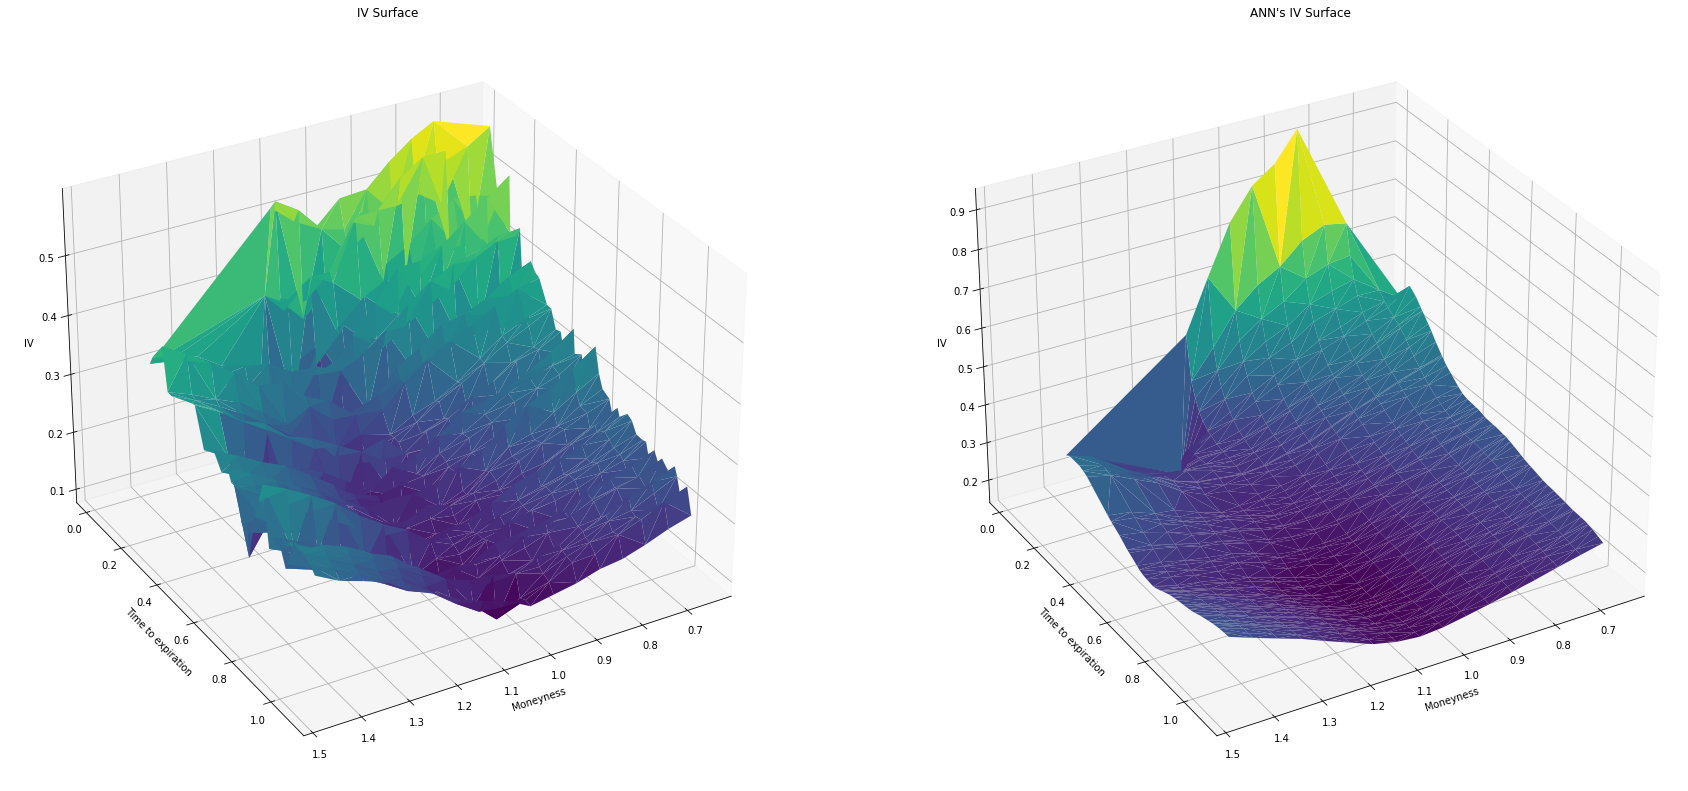

In [50]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, Z_axis, 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('IV Surface')
ax.view_init(30, 60)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, put_sample_iv['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('ANN\'s IV Surface')
ax.view_init(30, 60)
plt.savefig('../results/heston_iv_surface.png', dpi=300)
plt.show()

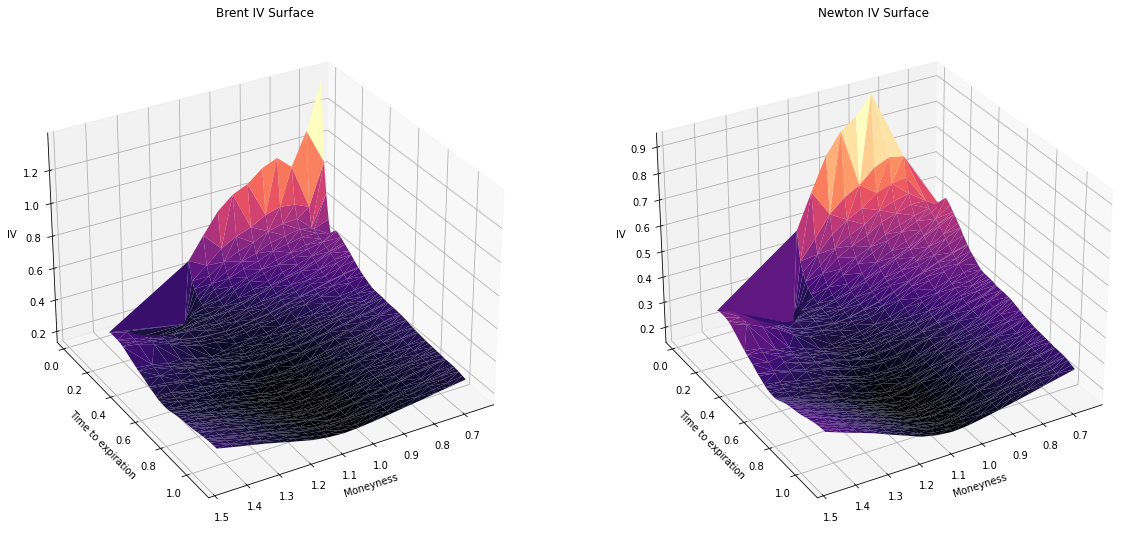

In [51]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_trisurf(X_axis_, Y_axis_, put_sample_iv_['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='magma')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('Brent IV Surface')
ax.view_init(30, 60)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(X_axis, Y_axis, put_sample_iv['Model IV'], 
                linewidth=0.2, antialiased=True, cmap='magma')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('Newton IV Surface')
ax.view_init(30, 60)